# 生存時間分析
## 〜薬物利用から次の利用までの経過時間に関する時間分析〜

# 環境設定
本分析では、pipenvでの環境構築を行う
```bash
# Python: 3.11.7を利用した
pipenv --python 3.11.7
pipenv shell
pip install -r requirements.txt
```

In [149]:
from SurvSet.data import SurvLoader
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import numpy as np
import missingno as msno
from ydata_profiling import ProfileReport
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test, proportional_hazard_test
from itertools import combinations

# データセットの読み込みとcsv形式での保存
- 本分析では、**麻薬中毒者の再使用に関するデータ**をSurvSetから利用した。
- csvでの保存は、`src` に保存される


In [75]:

#^ データセットの種類を取得
loader = SurvLoader()

#^ データセットの名前を取得してファイルに保存
list = loader.df_ds.ds
input = ""
for ds in list:
    input += ds+"\n"
with open("src/df_ds_name.txt", "w") as f:
    f.write(input)

#^ 麻薬中毒者の再使用に関するデータセットを読み込むみ、一応csvファイルとして保存する
df, ref = loader.load_dataset(ds_name="uis").values()
with open("src/uis_data.csv", "w") as f:
    f.write(df.to_csv(index=True))
with open("src/uis_ref.txt", "w") as f:
    f.write(ref)

# 探索的データ分析

## データフレームの形式や基本統計量の把握

## Ref

```txt
Description of the variables in the UIS Study described in Table 1.3
 of Hosmer, D.W. and Lemeshow, S. and May, S. (2008) Applied Survival
 Analysis: Regression Modeling of Time to Event Data: Second Edition,
John Wiley and Sons Inc., New York, NY


Data are in the file uis.dat

n = 628


Variable      Description                       Codes/Values                日本語での解説(col_name)
id            Identification Code               1 - 628                     通し番号(time)
age           Age at Enrollment                 Years                       年齢(num_age)
beck          Beck Depression Score             0.000 - 54.000              ベック抑うつスコア(num_beck)
                                                                            [指標に関して関連](https://www.sannoclinic.jp/bdi.html)
                at Admission
hercoc        Heroin/Cocaine Use During         1 = Heroin & Cocaine        ヘロイン, コカイン使用状況(fac_heroic)
                3 Months Prior to Admission     2 = Heroin Only
                                                3 = Cocaine Only
                                                4 = Neither Heroin
                                                    nor Cocaine
ivhx          IV Drug Use History at            1 = Never                   静脈注射薬利用歴(fac_ivhx)
                Admission                       2 = Previous
                                                3 = Recent
ndrugtx       Number of Prior Drug              0 - 40                      過去の薬物治療回数(num_ndrugtx)
                Treatments
race          Subject's Race                    0 = White                   人種(fac_race)
                                                1 = Other
treat         Treatment Randomization           0 = Short                   治療ランダム割り付け_治療期間の長さ(fac_treat)
                Assignment                      1 = Long
site          Treatment Site                    0 = A                       治療施設(fac_site)
                                                1 = B
time          Time to Return to Drug Use        Days                        薬物再使用までの期間(time)
                (Measured from Admission)
event         Returned to Drug Use              1 = Returned to Drug Use    薬物再使用の有無(event)
                                                0 = Otherwise
```

### 先頭3行確認

In [76]:
df.head(3)

pid  event  time fac_heroic fac_ivhx fac_race fac_treat fac_site  num_age  \
0    0      1   188          4        3        0         1        0     39.0   
1    1      1    26          4        2        0         1        0     33.0   
2    2      1   207          2        3        0         1        0     33.0   

   num_beck  num_ndrugtx  
0       9.0          1.0  
1      34.0          8.0  
2      10.0          3.0

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pid          628 non-null    int64   
 1   event        628 non-null    int64   
 2   time         628 non-null    int64   
 3   fac_heroic   628 non-null    category
 4   fac_ivhx     628 non-null    category
 5   fac_race     628 non-null    category
 6   fac_treat    628 non-null    category
 7   fac_site     628 non-null    category
 8   num_age      623 non-null    float64 
 9   num_beck     595 non-null    float64 
 10  num_ndrugtx  611 non-null    float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 32.8 KB


In [78]:
col_list = df.columns.tolist()

In [79]:
df.isnull().sum()

pid             0
event           0
time            0
fac_heroic      0
fac_ivhx        0
fac_race        0
fac_treat       0
fac_site        0
num_age         5
num_beck       33
num_ndrugtx    17
dtype: int64

<Axes: >

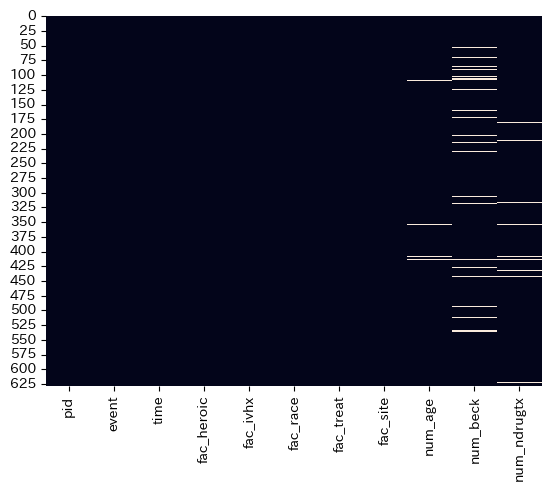

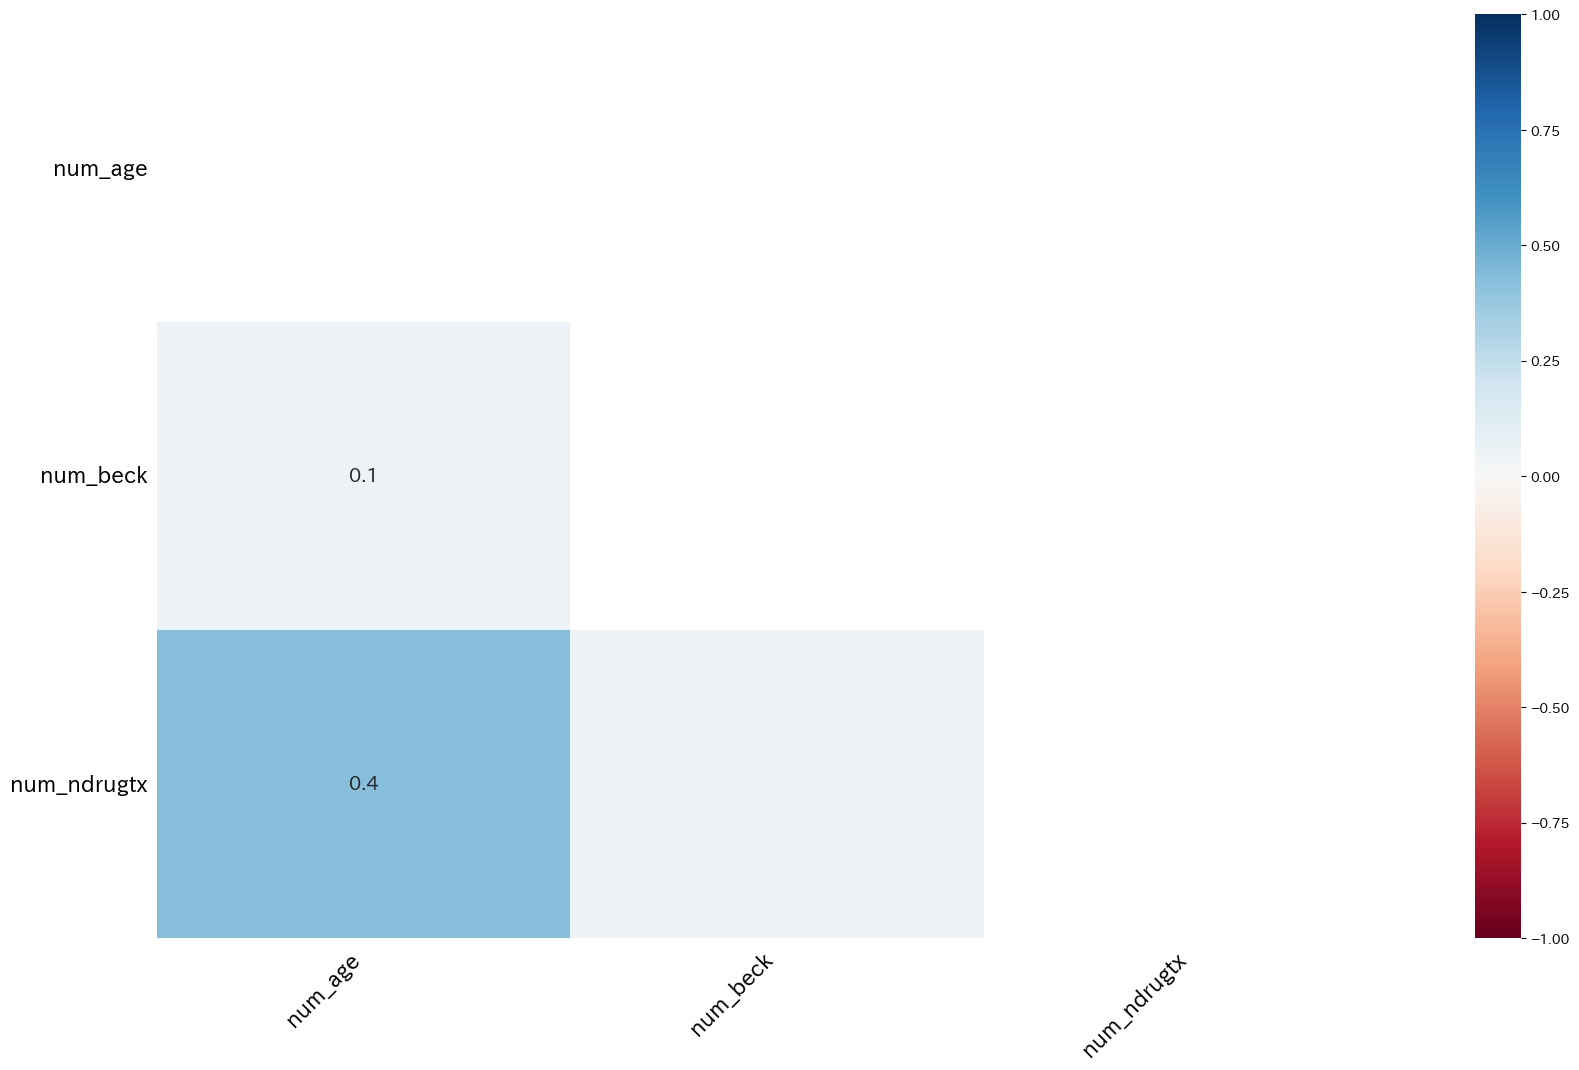

In [80]:
sns.heatmap(df.isnull(), cbar=False)
msno.heatmap(df)

### カテゴリ変数でない列の基本統計量

In [81]:
df.describe()

pid       event         time     num_age    num_beck  \
count  628.000000  628.000000   628.000000  623.000000  595.000000   
mean   313.500000    0.808917   234.703822   32.369181   17.404855   
std    181.432265    0.393468   201.701126    6.119534    9.391132   
min      0.000000    0.000000     2.000000   20.000000    0.000000   
25%    156.750000    1.000000    79.000000   27.000000   10.000000   
50%    313.500000    1.000000   166.000000   32.000000   17.000000   
75%    470.250000    1.000000   365.250000   37.000000   23.000000   
max    627.000000    1.000000  1172.000000   56.000000   54.000000   

       num_ndrugtx  
count   611.000000  
mean      4.574468  
std       5.494462  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       6.000000  
max      40.000000

## 割合の把握

- eventについて   
    0が未再使用, 1が再使用になる。
    - 未再使用等:薬物1回目の使用後に、2回目の利用が観察期間内に観察できていない個体 
    - 再使用: 薬物1回目の使用後に、2回目の利用を観察期間内に観察できた個体
- グラフからわかること
    - 再使用等が80.9%であり、ほとんどの薬物使用者が複数回の利用を行っていることがわかる。
    - 治療の有無により変化しているかは、このグラフからは検討できない

event
1    508
0    120
Name: count, dtype: int64


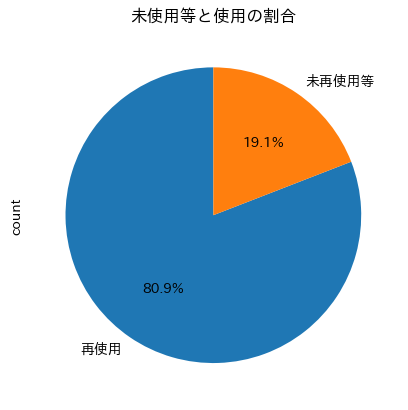

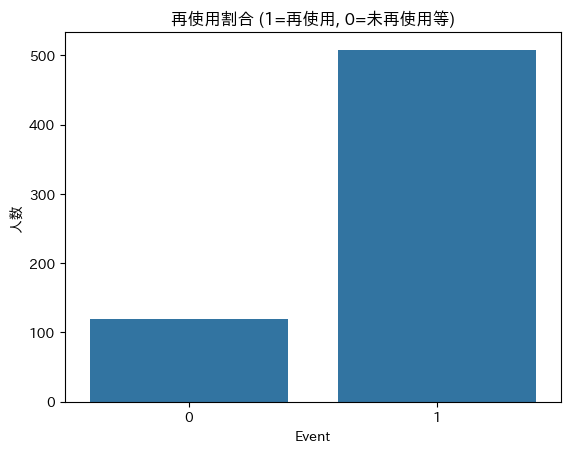

In [82]:
print(df['event'].value_counts())

# グラフ化
df['event'].value_counts().plot.pie(autopct='%1.1f%%', labels=['再使用', '未再使用等'], startangle=90)
plt.title('未使用等と使用の割合')
plt.show()

sns.countplot(x='event', data=df)
plt.title('再使用割合 (1=再使用, 0=未再使用等)')
plt.xlabel('Event')
plt.ylabel('人数')
plt.show()

## 薬物再使用と時間の関係
- 全観察対象のうち、event==1であるレコードを抽出し、
- 1回目利用直後が最も高く、徐々に減少傾向であるとうかがえる。


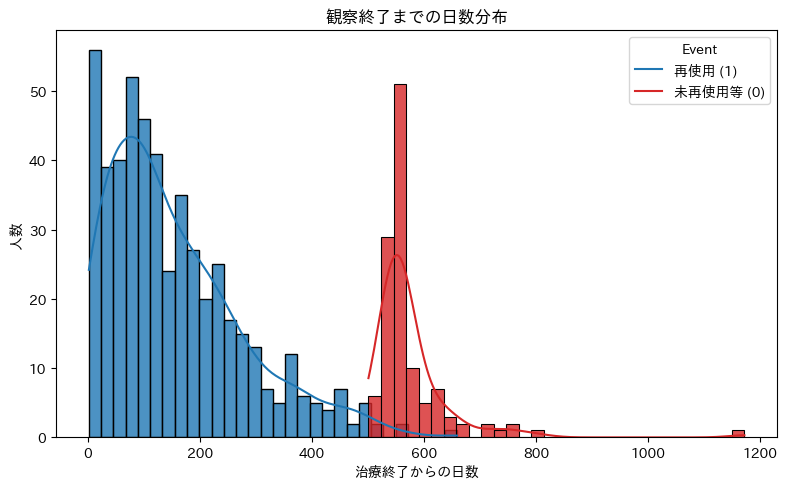

In [83]:
df_event1 = df[df["event"] == 1]    # 列名が censor の場合は df["censor"] == 1
df_event0 = df[df["event"] == 0]
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_event1,
    x="time",
    bins=30,
    kde=True,
    stat="count",
    color="tab:blue",
    edgecolor="black",
    alpha=0.8
)
sns.histplot(
    data=df_event0,
    x="time",
    bins=30,
    kde=True,
    stat="count",
    color="tab:red",
    edgecolor="black",
    alpha=0.8
)
plt.title("観察終了までの日数分布")
plt.xlabel("治療終了からの日数")
plt.legend(title='Event', labels=['再使用 (1)', '未再使用等 (0)'])
plt.ylabel("人数")
plt.tight_layout()
plt.savefig("output/plot/観察終了までの時間分布.png")
plt.show()

## 調査対象者の分布
- num_age(年齢)について   
    30代前半での調査対象者割合が多い
- num_beckについて
- num_ndrugtxについて
- timeについて
    - 打ち切りタイミングは、500日以降から順次観測されている
    - 

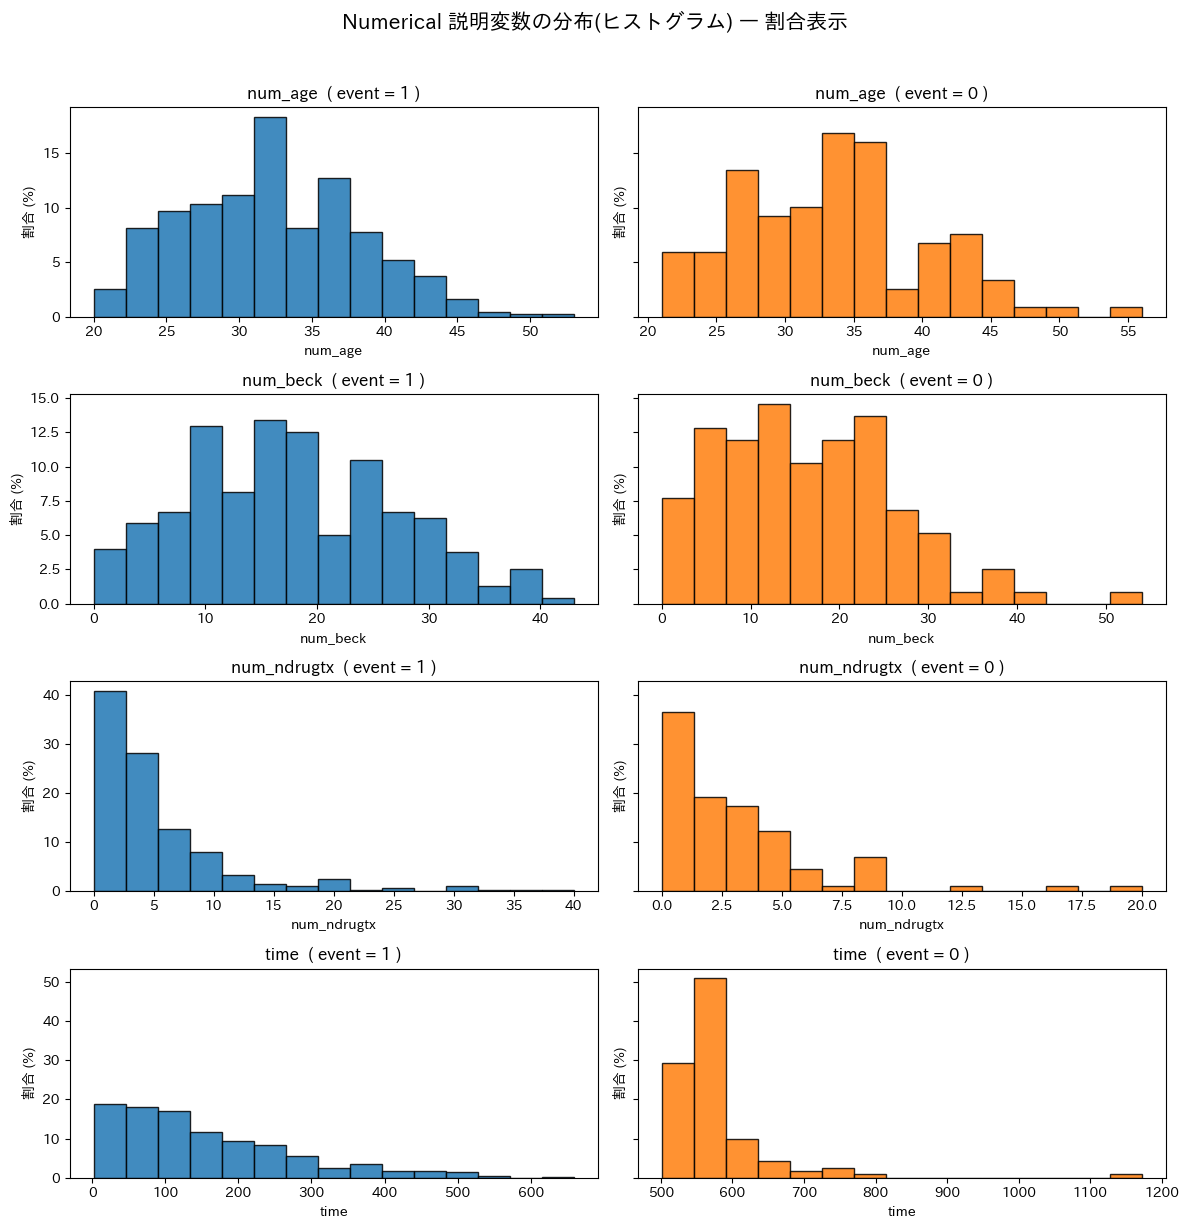

In [84]:

#^ 今回、plotの対象とするのは年齢, ベック鬱スコア, 過去の麻薬治療回数, 時間の4つである
numerical_cols = ["num_age", "num_beck", "num_ndrugtx", "time"]
event_col      = "event"

n_rows = len(numerical_cols)
fig, axes = plt.subplots(
    n_rows, 2, figsize=(12, 3 * n_rows),
    sharey="row"
)

for i, col in enumerate(numerical_cols):
    for j, ev in enumerate([1, 0]):
        ax   = axes[i, j]
        data = df.loc[df[event_col] == ev, col].dropna()
        #^ 割合表示
        weights = np.ones_like(data) / len(data) * 100

        ax.hist(
            data, bins=15, weights=weights,
            alpha=0.85, color=("tab:blue" if ev == 1 else "tab:orange"),
            edgecolor="black"
        )

        ax.set_title(f"{col}  ( {event_col} = {ev} )")
        ax.set_xlabel(col)
        ax.set_ylabel("割合 (%)")

plt.suptitle("Numerical 説明変数の分布(ヒストグラム) — 割合表示", y=1.02, fontsize=15)
plt.tight_layout()
plt.savefig("output/plot/num_説明変数の分布(ヒストグラム).png")
plt.show()

In [85]:

df_treatLONG = df[df["fac_treat"] == 1]
df_treatLONG.shape #^ 長期治療者が308人(308,11)

df_treatSHORT = df[df["fac_treat"] != 1]
df_treatSHORT.shape #^ 短期治療者が320人(320,11) 

(320, 11)

### 治療期間の長さによる、再使用までの時間推移比較
- event==1に限定しており、fac_treat==1の方が再使用までの期間が長い傾向があると伺える。
- 有意な差が生じているかは不明なため、、検定を実施する必要があると言える。

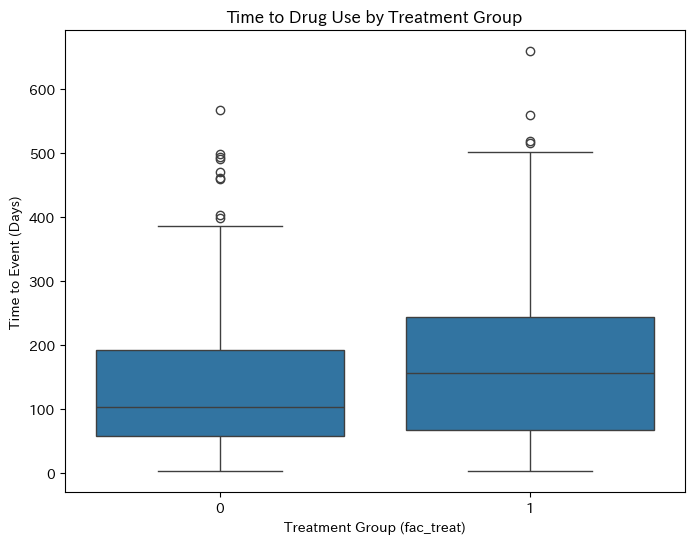

In [86]:

#^  fac_treat（0=Short, 1=Long）ごとの生存時間を可視化
plt.figure(figsize=(8,6))
sns.boxplot(x='fac_treat', y='time', data=df_event1)
plt.title('Time to Drug Use by Treatment Group')
plt.xlabel('Treatment Group (fac_treat)')
plt.ylabel('Time to Event (Days)')
plt.show()

### 静脈注射による薬物投与歴
> 1: Never(一度もない), 2: Previous(過去にあり), 3: Recent(最近)    

静脈注射は、、従来の薬物利用方法と比較すると依存度が高いと推測できる。   
また、本データからも、Neverと利用歴があるセグメントで比較すると、第三四分位点が大きく異なっているため、何らかの差があると推測できる。


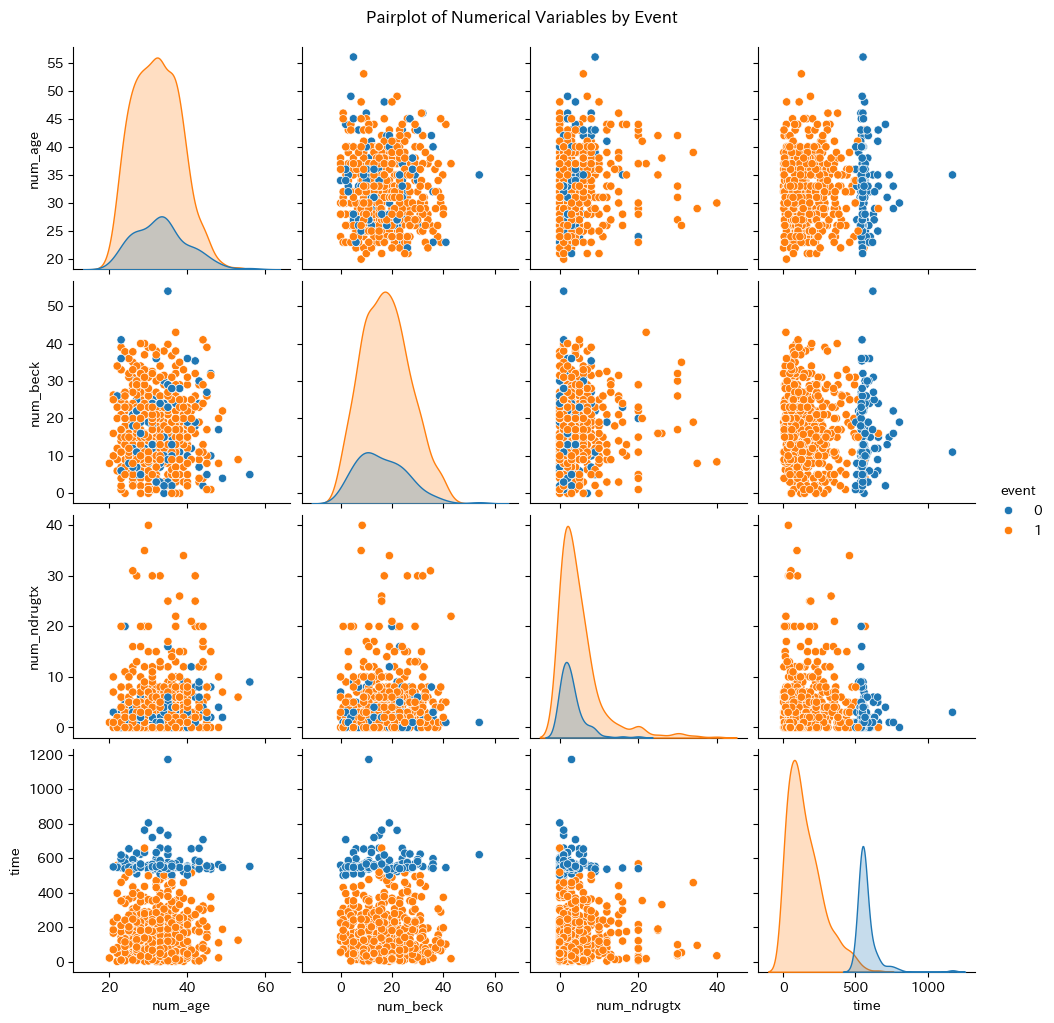

In [87]:
sns.pairplot(df, vars=['num_age', 'num_beck', 'num_ndrugtx', 'time'], hue='event')
plt.suptitle('Pairplot of Numerical Variables by Event', y=1.02)
plt.show()

In [88]:
# プロファイルレポートの作成
profile = ProfileReport(df, title="UIS Dataset EDA Report", explorative=True)

# Jupyter Notebookなら
profile.to_notebook_iframe()

python(31712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 100736.56it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
profile.to_file("output/uis_eda_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 分析

In [90]:

#^ フィッティングのため、欠損値を含むレコードの
df_model = df.dropna()
mask = df_model.isin(['missing']).any(axis=1)
df_model = df_model[~mask].reset_index(drop=True)
df_model.drop(columns=['pid'], inplace=True)

# ダミー変数化する列
cat_cols = ['fac_heroic', 'fac_ivhx', 'fac_race', 'fac_treat', 'fac_site']
df_encoded = pd.get_dummies(
    df_model,
    columns=cat_cols,
    drop_first=True
)
df_encoded = df_encoded.drop(columns=['time','event','fac_heroic_missing','fac_ivhx_missing','fac_race_missing'])
df_encoded = pd.concat([df_model['time'], df_model['event'], df_encoded], axis=1) 
df_model = df_model.apply(lambda col: pd.to_numeric(col, errors='coerce').astype(int))

df_encoded.head()

time  event  num_age  num_beck  num_ndrugtx  fac_heroic_2  fac_heroic_3  \
0   188      1     39.0       9.0          1.0         False         False   
1    26      1     33.0      34.0          8.0         False         False   
2   207      1     33.0      10.0          3.0          True         False   
3   144      1     32.0      20.0          1.0         False         False   
4   551      0     24.0       5.0          5.0          True         False   

   fac_heroic_4  fac_ivhx_2  fac_ivhx_3  fac_race_1  fac_treat_1  fac_site_1  
0          True       False        True       False         True       False  
1          True        True       False       False         True       False  
2         False       False        True       False         True       False  
3          True       False        True       False        False       False  
4         False       False       False        True         True       False

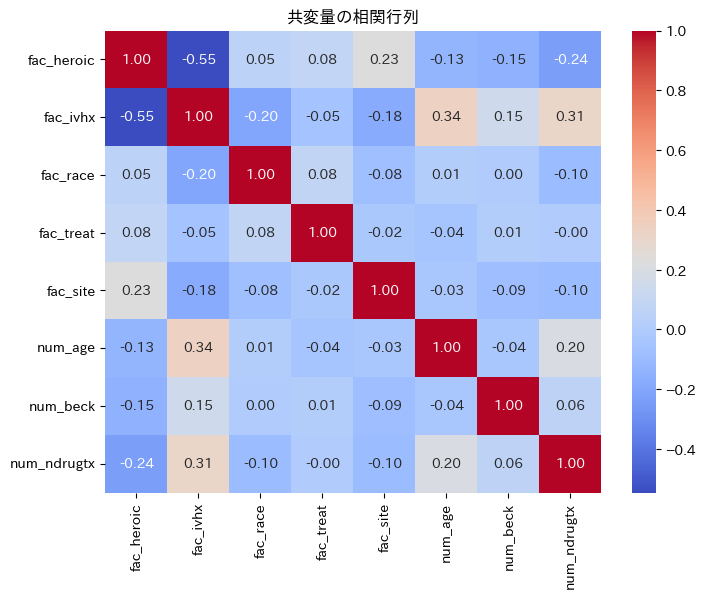

In [91]:
corr = df_model.drop(columns=['time','event']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("共変量の相関行列")
plt.show()

In [92]:

#^ Function to create Kaplan-Meier plots
def kaplan_meier_plot(col_name,title,
                      check=True,
                      df=df_encoded
                      ):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10,6))
    for name, group in df.groupby(col_name):
        T = group['time']
        E = group['event']
        kmf.fit(T, event_observed=E, label=f'{col_name} {name}')
        kmf.plot_survival_function(ci_show=True)
        sf = kmf.survival_function_
        if check:
            print(f"--- fac_heroic {name} ---")
            print(sf.head(), "\n")
    plt.title(f'{title}別のKaplan-Meier曲線')
    plt.xlabel('プログラム終了からの経過日数')
    plt.ylabel('生存率(再使用していない人の割合)')
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.savefig(f"output/plot/{title}_km_plot.png")
    plt.show()

In [93]:

#^ Function to logrank test between some groups
def logrank_test_multiple_groups(group_col,time_col="time",event_col="event", df=df_model):
    results = multivariate_logrank_test(
        df[time_col],
        df[group_col],
        df[event_col]
    )
    return results.summary

In [94]:

#^ ペアワイズログランク検定を行い、p値を行列表現で返す関数
def pairwise_logrank_matrix(df=df_model, group_col="fac_ivhx", time_col='time', event_col='event', correction=None):
    """
    複数グループのペアワイズログランク検定を実行し、
    Bonferroni 補正済みの p 値を行列表現で返す関数。

    Parameters:
    - df: pandas DataFrame
    - group_col: 群ラベルの列名
    - time_col: 生存時間の列名（デフォルト 'time'）
    - event_col: イベント発生フラグの列名（デフォルト 'event'）
    - correction: 'bonferroni' で補正、それ以外は未補正

    Returns:
    - pandas DataFrame: 行・列ともに群ラベル、要素は補正後 p 値（対角は NaN）
    """
    groups = df[group_col].dropna().unique()
    m = len(groups) * (len(groups) - 1) // 2
    p_mat = pd.DataFrame(np.nan, index=groups, columns=groups, dtype=float)
    for g1, g2 in combinations(groups, 2):
        d1 = df[df[group_col] == g1]
        d2 = df[df[group_col] == g2]
        res = logrank_test(
            d1[time_col], d2[time_col],
            event_observed_A=d1[event_col],
            event_observed_B=d2[event_col]
        )
        p_raw = res.p_value
        p_adj = min(p_raw * m, 1.0) if correction == 'bonferroni' else p_raw
        p_mat.loc[g1, g2] = p_adj
        p_mat.loc[g2, g1] = p_adj

    return p_mat

## ヘロインコカイン使用歴に関する分析

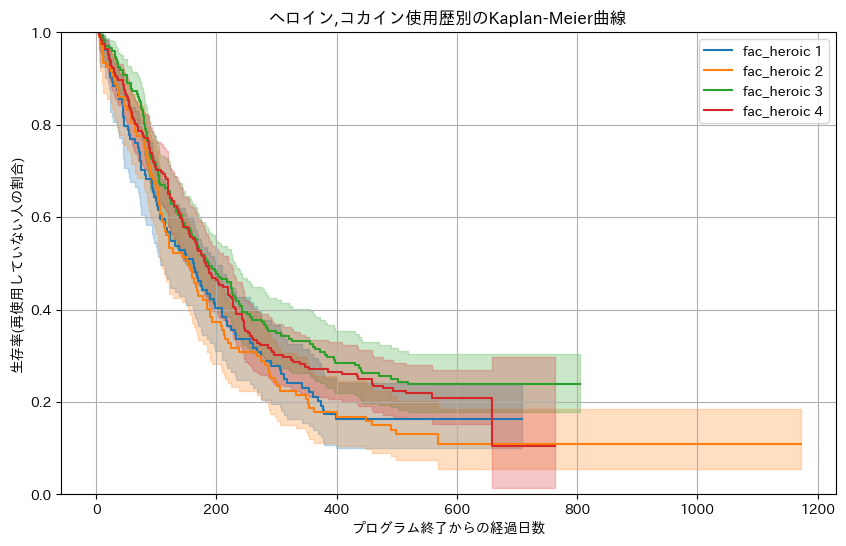

In [95]:
kaplan_meier_plot("fac_heroic", "ヘロイン,コカイン使用歴",check=False, df=df_model)

In [96]:
logrank_test_multiple_groups("fac_heroic")

test_statistic         p  -log2(p)
0        7.739107  0.051723  4.273056

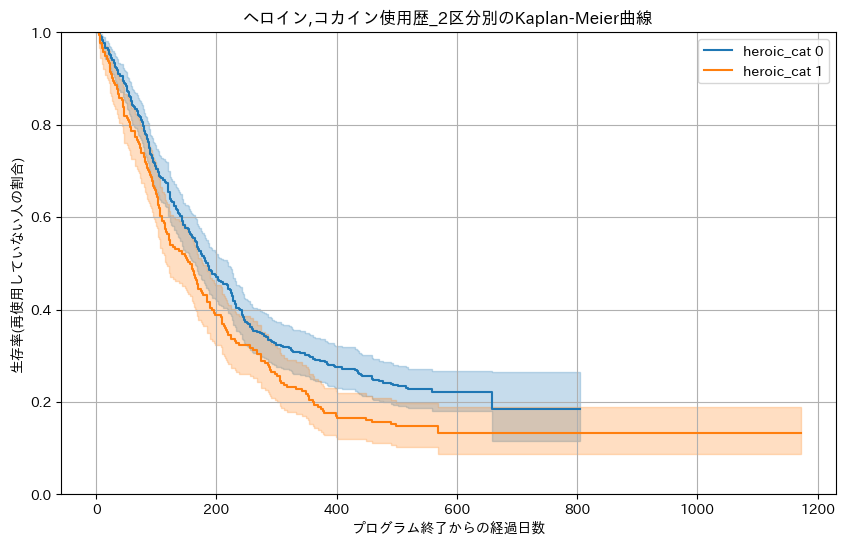

In [97]:
df_model['heroic_cat'] = df_model['fac_heroic'].isin([1, 2]).astype(int)
kaplan_meier_plot("heroic_cat", "ヘロイン,コカイン使用歴_2区分",check=False, df=df_model)

In [98]:
logrank_test_multiple_groups("heroic_cat", df=df_model)

test_statistic         p  -log2(p)
0        7.036792  0.007985  6.968457

## 静脈注射について

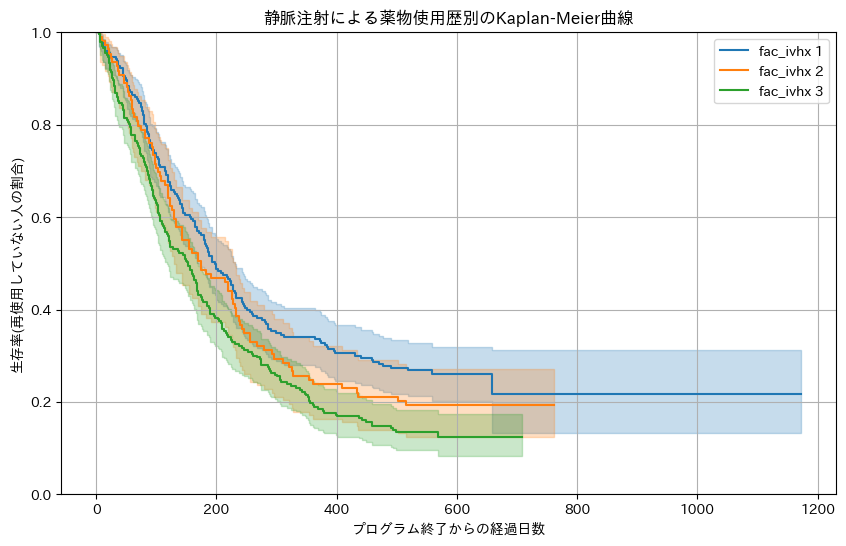

test_statistic         p  -log2(p)
0       13.723916  0.001047  9.899713

In [99]:
kaplan_meier_plot("fac_ivhx", "静脈注射による薬物使用歴",check=False, df=df_model)
logrank_test_multiple_groups("fac_ivhx", df=df_model)

In [100]:
pairwise_logrank_matrix(df=df_model, 
                        group_col='fac_ivhx', 
                        time_col='time', 
                        event_col='event',
                        correction='bonferroni'
                        )

3         2         1
3       NaN  0.327842  0.000681
2  0.327842       NaN  0.535419
1  0.000681  0.535419       NaN

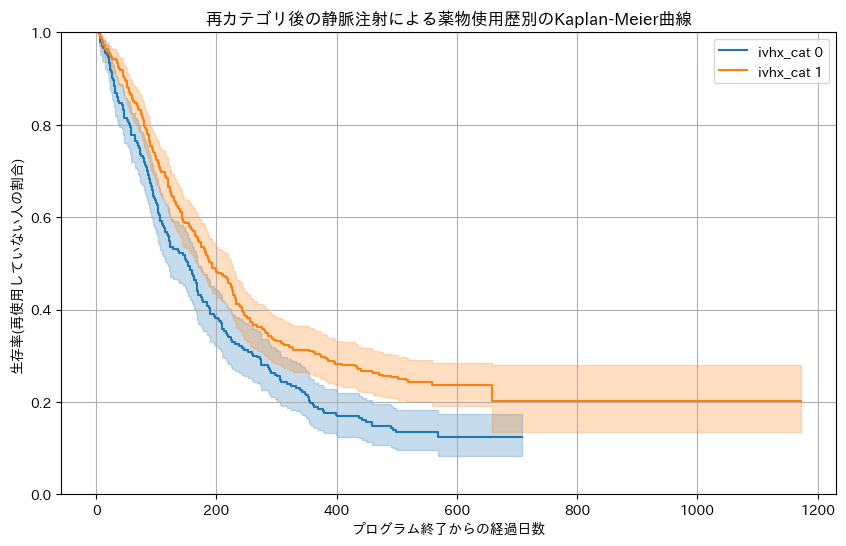

test_statistic         p   -log2(p)
0       12.102677  0.000503  10.955735

In [101]:
df_model["ivhx_cat"] = df_model["fac_ivhx"].isin([1, 2]).astype(int)
kaplan_meier_plot("ivhx_cat", "再カテゴリ後の静脈注射による薬物使用歴",check=False, df=df_model)
logrank_test_multiple_groups("ivhx_cat", df=df_model)


## fac_race 白人か否か

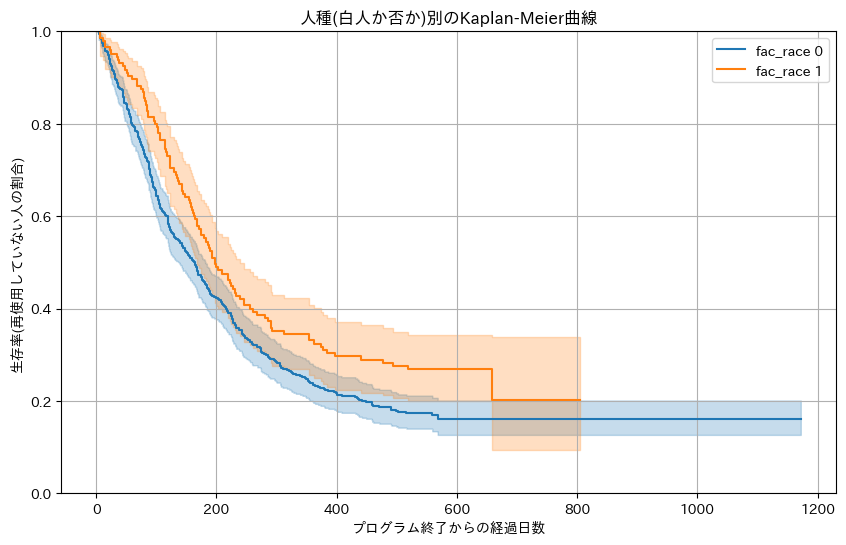

test_statistic         p  -log2(p)
0        7.431122  0.006411  7.285339

In [102]:
kaplan_meier_plot("fac_race", "人種(白人か否か)",check=False, df=df_model)
logrank_test_multiple_groups("fac_race", df=df_model)

## fac_treat
- 治療プロジェクトの種類

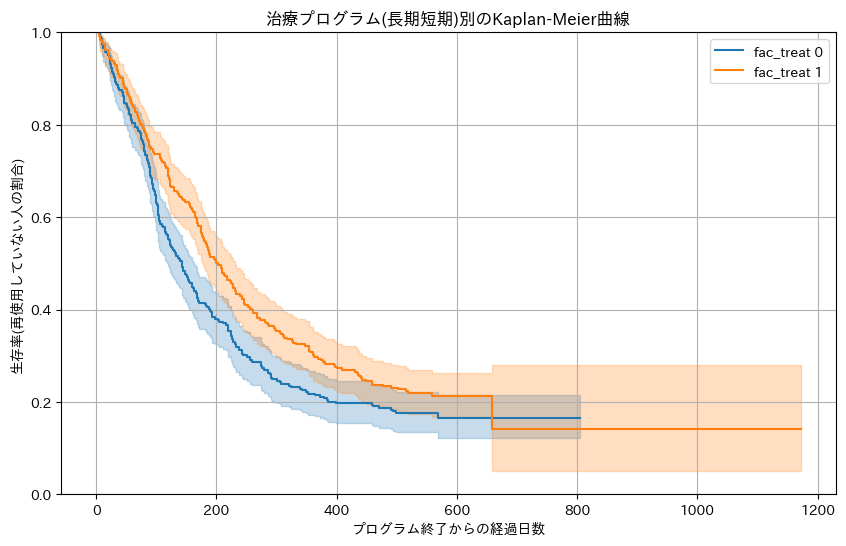

test_statistic         p  -log2(p)
0        6.528395  0.010617  6.557539

In [103]:
kaplan_meier_plot("fac_treat", "治療プログラム(長期短期)",check=False, df=df_model)
logrank_test_multiple_groups("fac_treat", df=df_model)

## fac_site(治療施設種別)

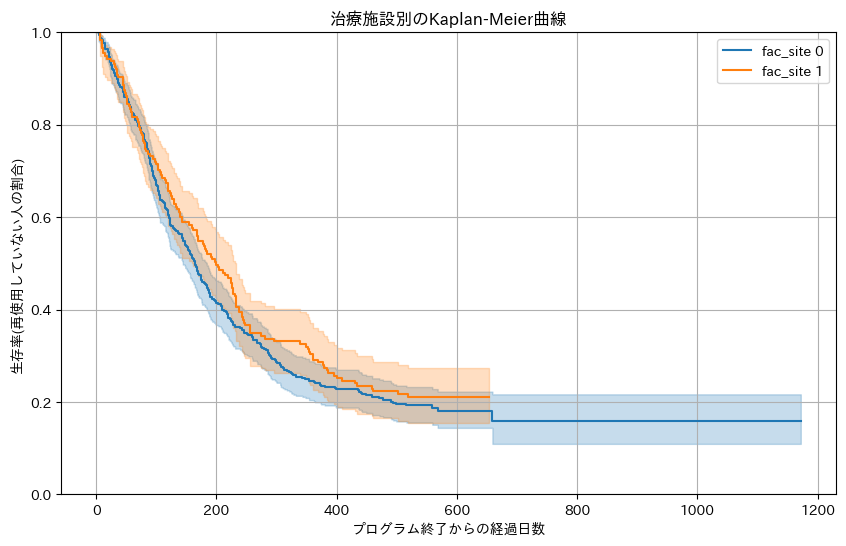

test_statistic         p  -log2(p)
0        1.091169  0.296212  1.755296

In [104]:
kaplan_meier_plot("fac_site", "治療施設",check=False, df=df_model)
logrank_test_multiple_groups("fac_site", df=df_model)

## fac_treat * fac_site


In [105]:
df_model['treat_site'] = df_model['fac_treat'].astype(str) + '_' + df_model['fac_site'].astype(str)

mapping = {
    '0_0': 'Short_A',  # 短期プログラム × サイトA
    '0_1': 'Short_B',  # 短期プログラム × サイトB
    '1_0': 'Long_A',   # 長期プログラム × サイトA
    '1_1': 'Long_B'    # 長期プログラム × サイトB
}
df_model['treat_site'] = df_model['treat_site'].map(mapping).astype('category')


/var/folders/wb/sqvg1jfx4qvbgf2ndb8gt5300000gn/T/ipykernel_14688/2736816905.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby(col_name):


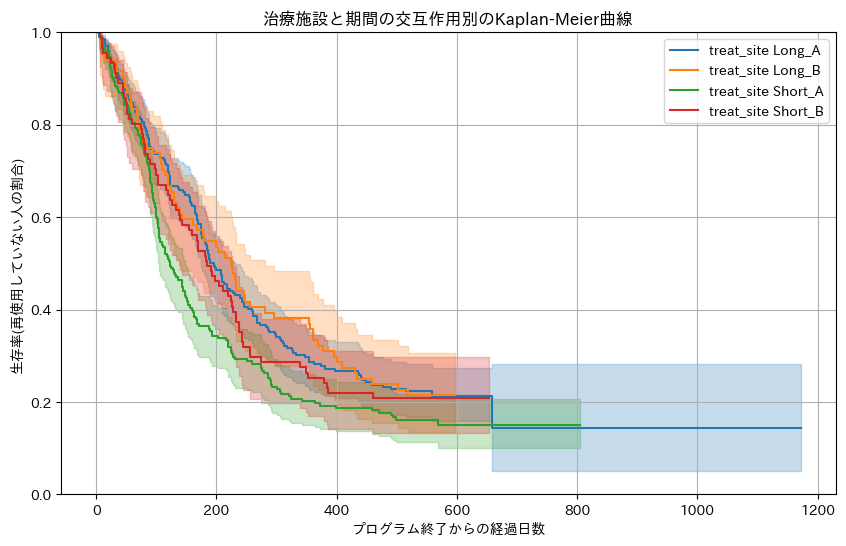

test_statistic         p  -log2(p)
0        9.089898  0.028119    5.1523

In [106]:
kaplan_meier_plot("treat_site", "治療施設と期間の交互作用",check=False, df=df_model)
logrank_test_multiple_groups("treat_site", df=df_model)

In [107]:
pairwise_logrank_matrix(
    df=df_model, 
    group_col='treat_site', 
    time_col='time', 
    event_col='event',
    correction='bonferroni'
)

Long_A   Short_A   Short_B    Long_B
Long_A        NaN  0.039431  1.000000  1.000000
Short_A  0.039431       NaN  0.808129  0.193267
Short_B  1.000000  0.808129       NaN  1.000000
Long_B   1.000000  0.193267  1.000000       NaN

- 解釈
	-	サイト A においては、「長期プログラム（Long_A）」と「短期プログラム（Short_A）」で再使用までの時間に統計的に有意な差がある。
	-	サイト B では、「Long_B vs Short_B」の差は有意でなく、プログラムの長さによる効果は観測できなかった。
	-	サイト間をまたいだ比較（例：Long_A vs Long_B）にも有意差はない。

- つまり、治療期間の効果（長期 vs 短期）はサイト A でのみ顕著であり、サイト B ではプログラム期間の違いが生存曲線に反映されていない、ということが示唆されます。

## num_age (年齢)

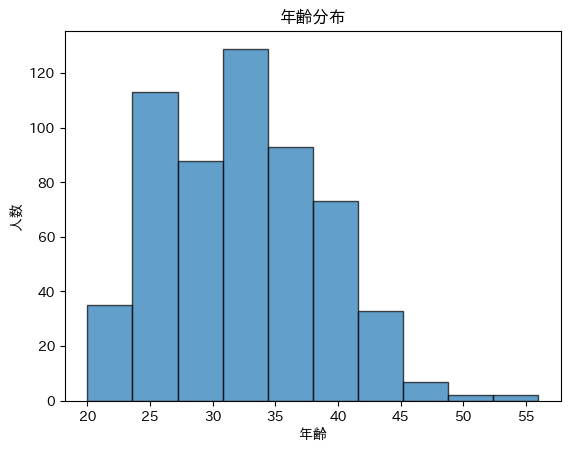

In [108]:
plt.hist(df_model['num_age'], bins=10, edgecolor='black', alpha=0.7)
plt.title('年齢分布')
plt.xlabel('年齢')
plt.ylabel('人数')
plt.show()

Age threshold (median): 32.0


age_cat
old      312
young    263
Name: count, dtype: int64

/var/folders/wb/sqvg1jfx4qvbgf2ndb8gt5300000gn/T/ipykernel_14688/2736816905.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby(col_name):


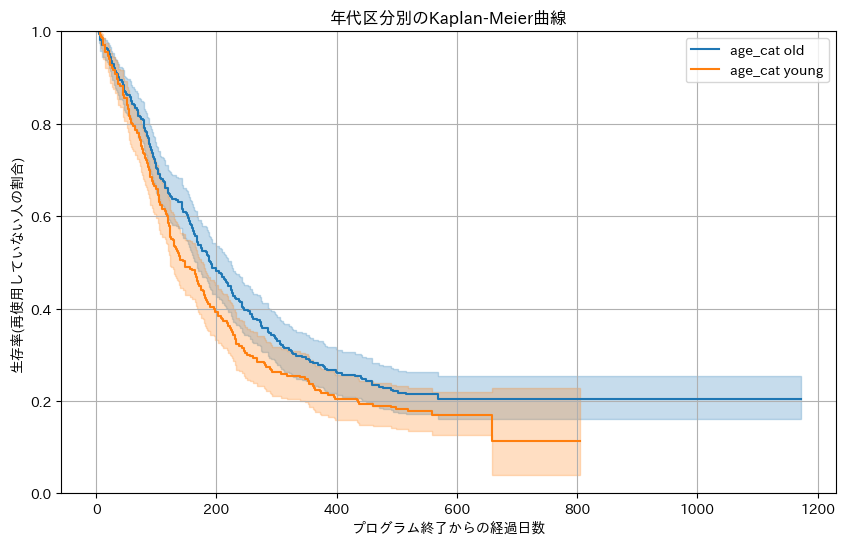

test_statistic         p  -log2(p)
0         3.90029  0.048278  4.372497

In [ ]:
threshold = df_model['num_age'].median()
print("Age threshold (median):", threshold)

df_model['age_cat'] = np.where(
    df_model['num_age'] < threshold,
    'young',
    'old'
)

df_model['age_cat'] = df_model['age_cat'].astype('category')

display(df_model["age_cat"].value_counts())
kaplan_meier_plot("age_cat", "年代区分",check=False, df=df_model)
logrank_test_multiple_groups("age_cat", df=df_model)


## beck_cat(抑うつスコアレベル)

In [110]:
df_model["beck_cat"] = pd.cut(
    df_model["num_beck"],
    bins=[-1, 9, 16, 23, 30],
    labels=["軽度", "中等度", "重度", "極重度"]
)

beck_cat
重度     154
中等度    152
軽度     130
極重度     83
Name: count, dtype: int64

/var/folders/wb/sqvg1jfx4qvbgf2ndb8gt5300000gn/T/ipykernel_14688/2736816905.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby(col_name):


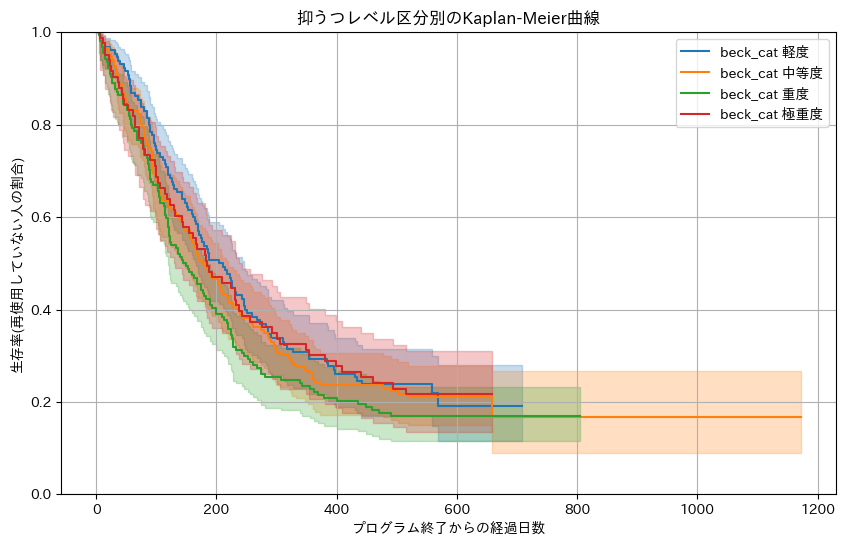

test_statistic         p  -log2(p)
0         4.05626  0.398445  1.327546

In [115]:
df_model['beck_cat'] = df_model['beck_cat'].astype('category')

display(df_model["beck_cat"].value_counts())
kaplan_meier_plot("beck_cat", "抑うつレベル区分",check=False, df=df_model)
logrank_test_multiple_groups("beck_cat", df=df_model)


In [120]:
df_model.head()

event  time  fac_heroic  fac_ivhx  fac_race  fac_treat  fac_site  num_age  \
0      1   188           4         3         0          1         0       39   
1      1    26           4         2         0          1         0       33   
2      1   207           2         3         0          1         0       33   
3      1   144           4         3         0          0         0       32   
4      0   551           2         1         1          1         0       24   

   num_beck  num_ndrugtx  heroic_cat  ivhx_cat treat_site age_cat beck_cat  \
0         9            1           0         0     Long_A     old       軽度   
1        34            8           0         1     Long_A     old      NaN   
2        10            3           1         0     Long_A     old      中等度   
3        20            1           0         0    Short_A     old       重度   
4         5            5           1         1     Long_A   young       軽度   

   beck_cat_2  
0        True  
1       False  
2        True  
3        True  
4        True

beck_cat_2
0    293
1    282
Name: count, dtype: int64

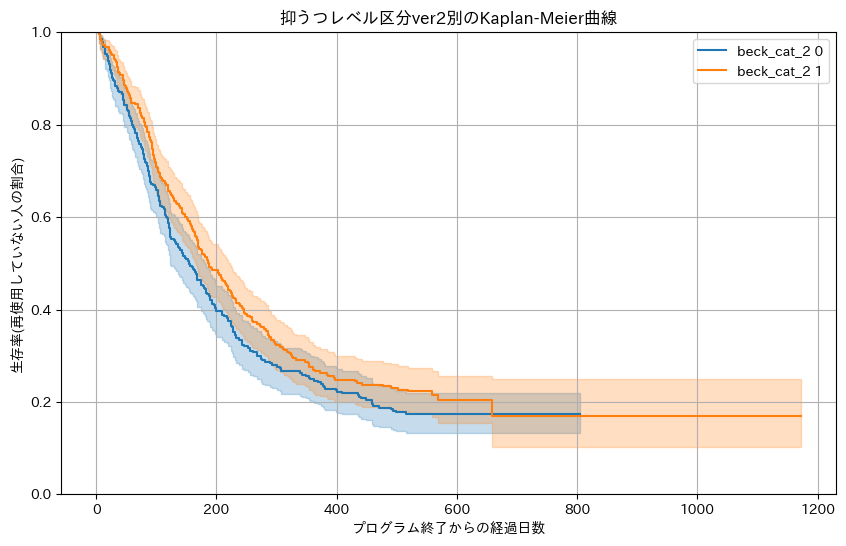

test_statistic        p  -log2(p)
0        3.248482  0.07149  3.806122

In [124]:
df_model['beck_cat_2'] = df_model['beck_cat'].isin(["軽度", "中等度"]).astype(int)

display(df_model["beck_cat_2"].value_counts())
kaplan_meier_plot("beck_cat_2", "抑うつレベル区分ver2",check=False, df=df_model)
logrank_test_multiple_groups("beck_cat_2", df=df_model)


# Cox回帰モデル

In [133]:
# 単変量解析したい説明変数リスト
vars_to_test = [
    'heroic_cat',
    'ivhx_cat',
    'num_ndrugtx',
    'fac_race',
    'fac_treat',
    'fac_site',
    'age_cat',
    'beck_cat_2'
]

for var in vars_to_test:
    # 対応する列だけ抽出して欠測行を除去
    df_temp = df_model[['time', 'event', var]].dropna()
    # カテゴリ変数は C() でラップ
    if df_temp[var].dtype.name == 'category' or df_temp[var].dtype == object:
        formula = f"C({var})"
    else:
        formula = var

    # 単変量 Cox モデルのフィッティング
    cph = CoxPHFitter()
    cph.fit(
        df_temp,
        duration_col='time',
        event_col='event',
        formula=formula
    )

    # 結果を表示
    print(f"\n=== Univariate Cox model for '{var}' ===")
    print(cph.summary)
    


=== Univariate Cox model for 'heroic_cat' ===
                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                   
heroic_cat  0.252438   1.287159  0.095325        0.065603        0.439272   

            exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                
heroic_cat             1.067803             1.551578     0.0  2.648168   

                   p  -log2(p)  
covariate                       
heroic_cat  0.008093  6.949121  

=== Univariate Cox model for 'ivhx_cat' ===
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
ivhx_cat  -0.323829   0.723374  0.093457          -0.507       -0.140657   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z        p  \
covariate                                   


=== Univariate Cox model for 'heroic_cat' ===
                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                   
heroic_cat  0.252438   1.287159  0.095325        0.065603        0.439272   

            exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                
heroic_cat             1.067803             1.551578     0.0  2.648168   

                   p  -log2(p)  
covariate                       
heroic_cat  0.008093  6.949121  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
heroic_cat            0.03 0.87      0.20


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

=== Univariate Cox model for 'ivhx_cat' ===
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
ivhx_cat  -0.323829   0.723374  0.093457          -0.507       -0.140657   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z        p  \
covariate                                                                       
ivhx_cat              0.602299             0.868787     0.0 -3.46501  0.00053   

            -log2(p)  
covariate             
ivhx_cat   10.881145  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic    p  -log2(p)
ivhx_cat            0.05 0.82      0.28


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

=== Univariate Cox model for 'num_ndrugtx' ===
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
num_ndrugtx  0.029579   1.030021  0.007739         0.01441        0.044748   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
num_ndrugtx             1.014514             1.045764     0.0  3.821851   

                    p   -log2(p)  
covariate                         
num_ndrugtx  0.000132  12.882222  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic    p  -log2(p)
num_ndrugtx            0.18 0.67      0.57


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

=== Univariate Cox model for 'fac_race' ===
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
fac_race  -0.299414   0.741253  0.110323       -0.515643       -0.083184   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z  \
covariate                                                              
fac_race              0.597116             0.920182     0.0 -2.71397   

                  p  -log2(p)  
covariate                      
fac_race   0.006648  7.232815  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic    p  -log2(p)
fac_race            1.33 0.25      2.01


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

=== Univariate Cox model for 'fac_treat' ===
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
fac_treat -0.237443   0.788642  0.093084       -0.419884       -0.055001   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
fac_treat             0.657123             0.946484     0.0 -2.550845   

                  p  -log2(p)  
covariate                      
fac_treat  0.010746  6.540027  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
fac_treat            3.26 0.07      3.82


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

=== Univariate Cox model for 'fac_site' ===
              coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                 
fac_site  -0.10647   0.899002  0.101678       -0.305756        0.092816   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
fac_site              0.736567              1.09726     0.0 -1.047125   

                  p  -log2(p)  
covariate                      
fac_site   0.295042  1.761008  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic    p  -log2(p)
fac_site            0.26 0.61      0.71


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

=== Univariate Cox model for 'age_cat' ===
                         coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
C(age_cat)[T.young]  0.183569   1.201498  0.093106        0.001084   

                     coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
C(age_cat)[T.young]        0.366055             1.001084             1.442034   

                     cmp to         z         p  -log2(p)  
covariate                                                  
C(age_cat)[T.young]     0.0  1.971606  0.048655  4.361278  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
C(age_cat)[T.young]            0.91 0.34      1.56


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

=== Univariate Cox model for 'beck_cat_2' ===
                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                   
beck_cat_2 -0.167599   0.845693  0.092996       -0.349868         0.01467   

            exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                
beck_cat_2             0.704781             1.014778     0.0 -1.802216   

                   p  -log2(p)  
covariate                       
beck_cat_2  0.071511  3.805683  

--- Schoenfeld residuals PH test ---


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
beck_cat_2            1.70 0.19      2.37


--- Checking PH assumptions with plots ---

   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


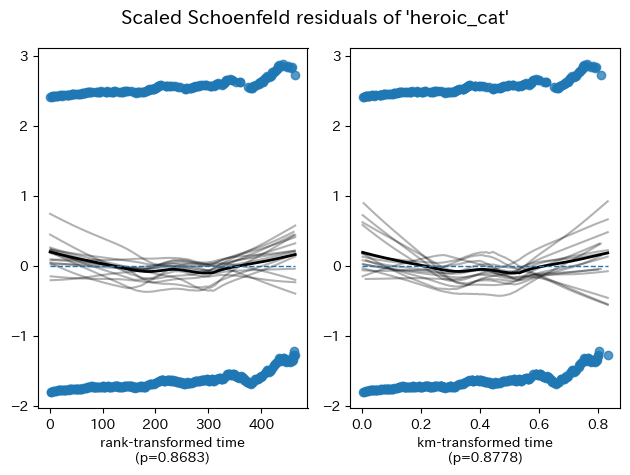

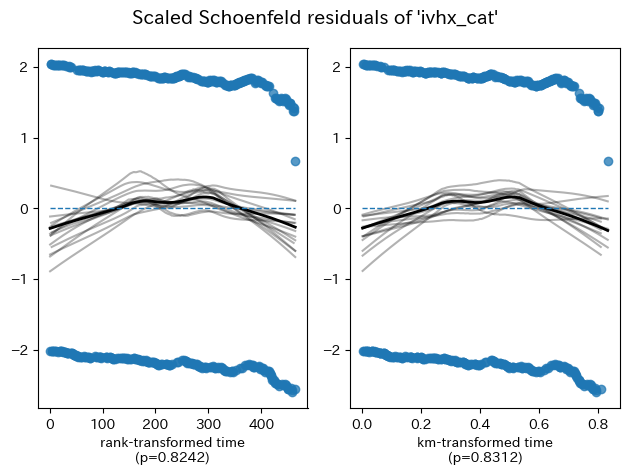

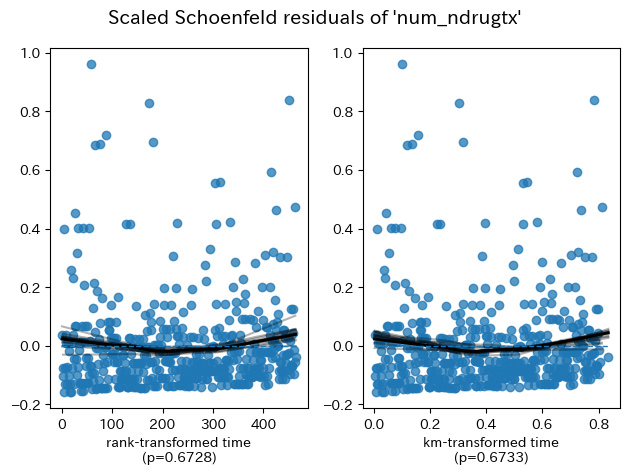

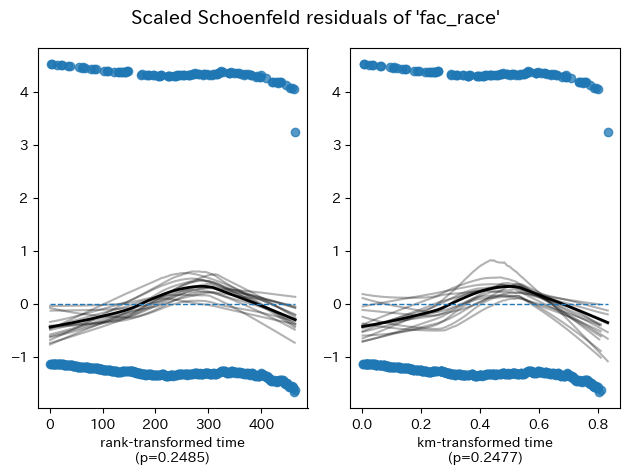

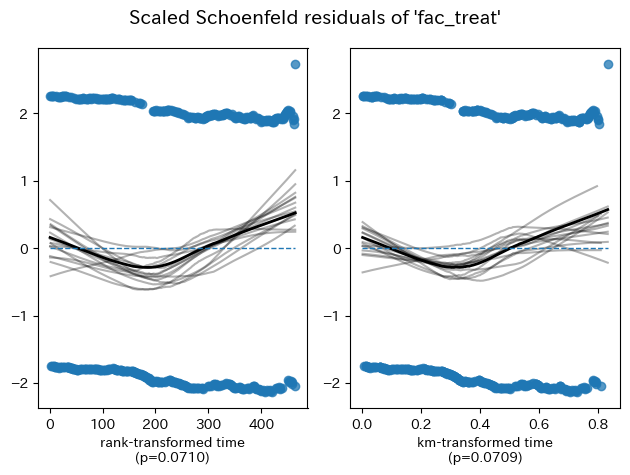

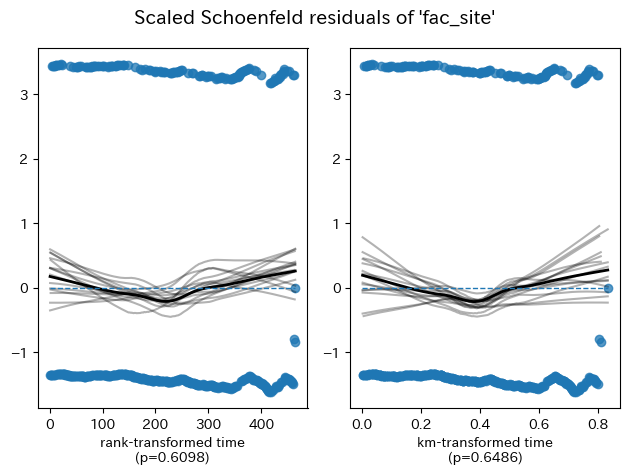

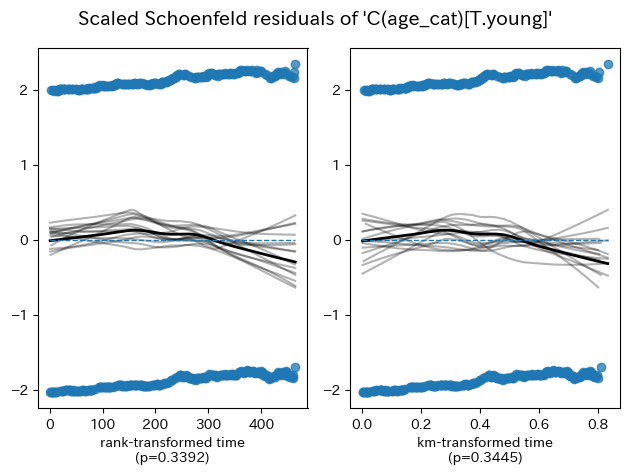

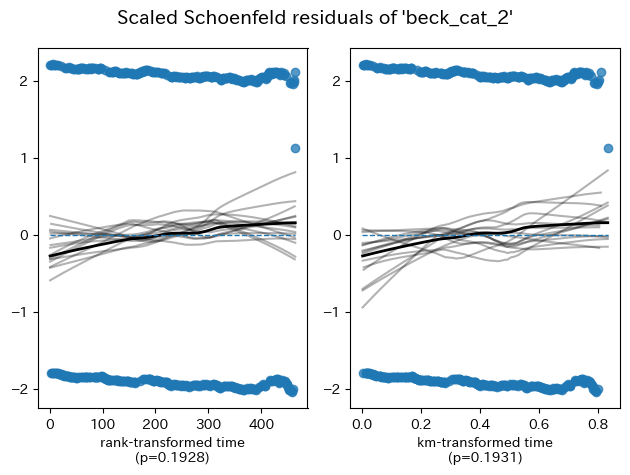

In [134]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# 単変量解析したい説明変数リスト
vars_to_test = [
    'heroic_cat',
    'ivhx_cat',
    'num_ndrugtx',
    'fac_race',
    'fac_treat',
    'fac_site',
    'age_cat',
    'beck_cat_2'
]

for var in vars_to_test:
    # 対応する列だけ抽出して欠測行を除去
    df_temp = df_model[['time', 'event', var]].dropna()
    # カテゴリ変数は C() でラップ
    if df_temp[var].dtype.name == 'category' or df_temp[var].dtype == object:
        formula = f"C({var})"
    else:
        formula = var

    # 単変量 Cox モデルのフィッティング
    cph = CoxPHFitter()
    cph.fit(
        df_temp,
        duration_col='time',
        event_col='event',
        formula=formula
    )

    # 結果を表示
    print(f"\n=== Univariate Cox model for '{var}' ===")
    print(cph.summary)

    # 1) Schoenfeld残差による比例ハザード性検定（Score 検定ではなく PH 性の検定）
    ph_test = proportional_hazard_test(
        cph,
        df_temp,
        time_transform='rank'  # 残差と時間のスケール変換方法
    )
    print("\n--- Schoenfeld residuals PH test ---")
    ph_test.print_summary()  # 各変数ごとの p 値を表示

    # 2) check_assumptions で残差プロットを表示
    print("\n--- Checking PH assumptions with plots ---")
    cph.check_assumptions(
        df_temp,
        show_plots=True,       # プロットを出力
        p_value_threshold=0.05 # 検定の有意水準
    )

=== Coefficients & Wald test ===
                         coef  exp(coef)  se(coef)         z         p
covariate                                                             
heroic_cat           0.085290   1.089032  0.128683  0.662789  0.507466
ivhx_cat            -0.290115   0.748177  0.127839 -2.269373  0.023246
fac_race            -0.250450   0.778450  0.111710 -2.241972  0.024963
C(age_cat)[T.young]  0.264451   1.302716  0.095500  2.769125  0.005621

=== Likelihood ratio test ===
χ² = 24.956, df = 4, p = 0.0001

=== Checking PH assumption ===

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.9890)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9818)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8602)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8628)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2984)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2974)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3180)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3247)'>]]

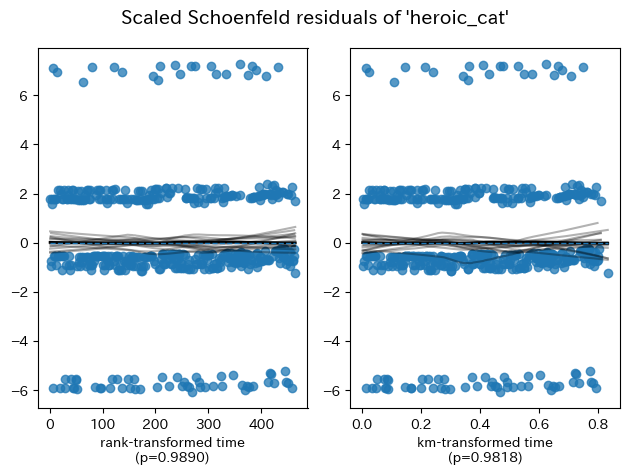

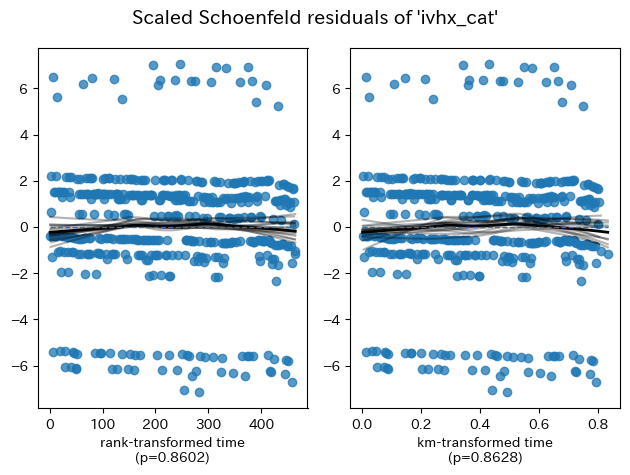

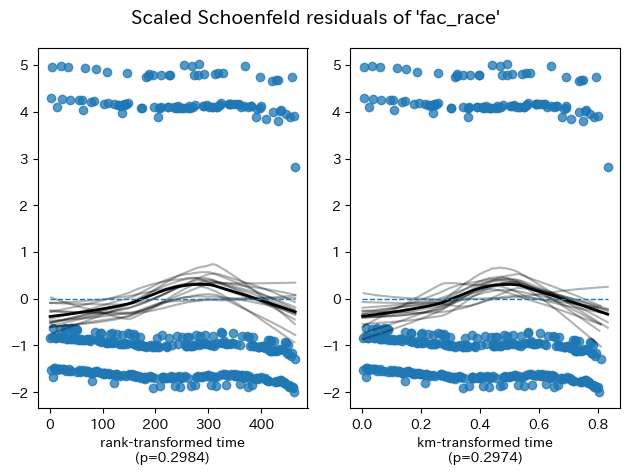

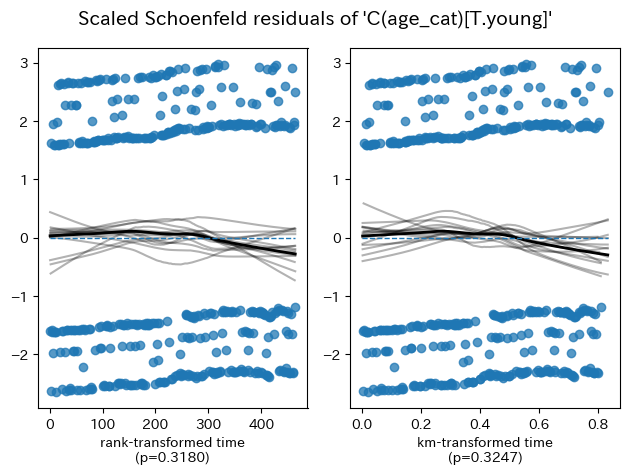

In [150]:

#^ 多変量Cox回帰モデル1 
sig_vars = ['heroic_cat', 'ivhx_cat','fac_race', 'age_cat']
df_multi = df_model[['time', 'event'] + sig_vars].dropna()

def wrap_if_cat(v):
    if df_multi[v].dtype.name == 'category' or df_multi[v].dtype == object:
        return f"C({v})"
    else:
        return v

formula = " + ".join(wrap_if_cat(v) for v in sig_vars)

cph = CoxPHFitter()
cph.fit(
    df_multi,
    duration_col='time',
    event_col='event',
    formula=formula  # e.g. "C(heroic_cat) + C(ivhx_cat) + fac_site"
)

print("=== Coefficients & Wald test ===")
print(cph.summary[['coef','exp(coef)','se(coef)','z','p']])

print("\n=== Likelihood ratio test ===")
lrt = cph.log_likelihood_ratio_test()
print(f"χ² = {lrt.test_statistic:.3f}, df = {lrt.degrees_freedom}, p = {lrt.p_value:.4f}")

print("\n=== Checking PH assumption ===")
cph.check_assumptions(
    df_multi,
    show_plots=True,
    p_value_threshold=0.05
)

=== Coefficients & Wald test ===
                         coef  exp(coef)  se(coef)         z         p
covariate                                                             
ivhx_cat            -0.345081   0.708163  0.096718 -3.567891  0.000360
fac_race            -0.248341   0.780094  0.111653 -2.224216  0.026134
C(age_cat)[T.young]  0.260333   1.297362  0.095264  2.732748  0.006281

=== Likelihood ratio test ===
χ² = 24.516, df = 3, p = 0.0000

=== Checking PH assumption ===

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.8199)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8293)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2947)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2936)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3063)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3126)'>]]

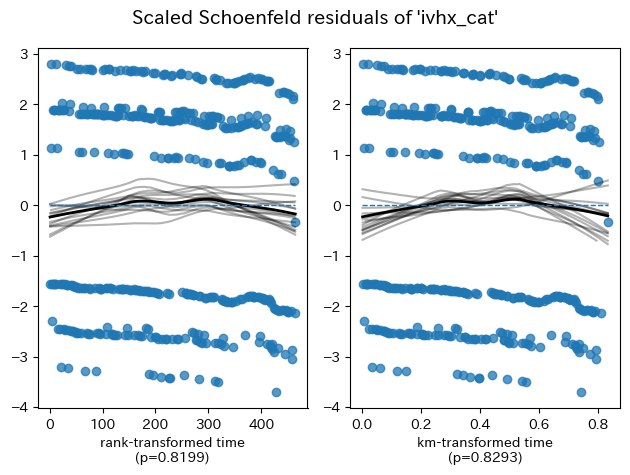

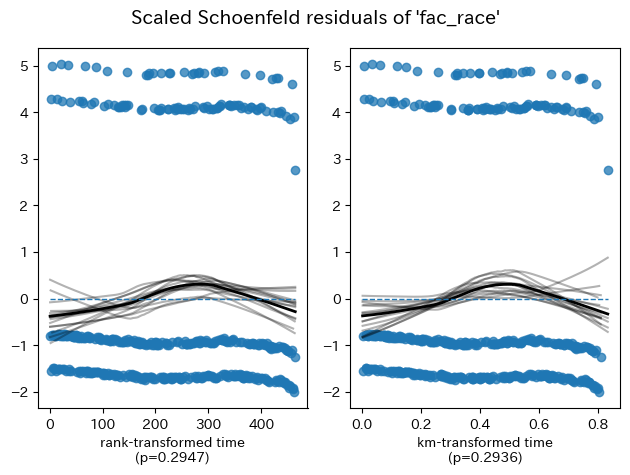

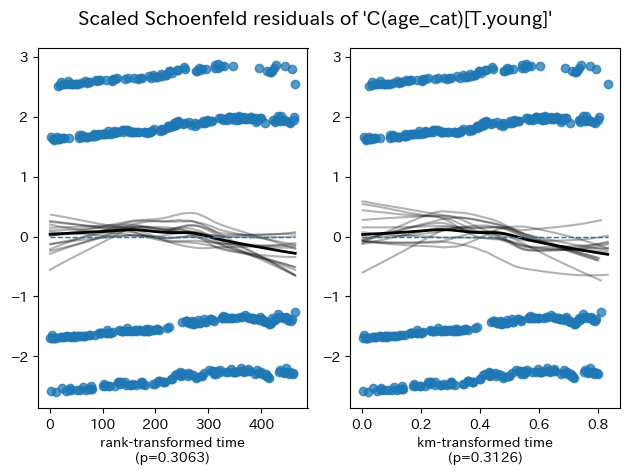

In [151]:

#^ 多変量Cox回帰モデル2
sig_vars = ['ivhx_cat','fac_race', 'age_cat']
df_multi = df_model[['time', 'event'] + sig_vars].dropna()

def wrap_if_cat(v):
    if df_multi[v].dtype.name == 'category' or df_multi[v].dtype == object:
        return f"C({v})"
    else:
        return v

formula = " + ".join(wrap_if_cat(v) for v in sig_vars)

cph = CoxPHFitter()
cph.fit(
    df_multi,
    duration_col='time',
    event_col='event',
    formula=formula  # e.g. "C(heroic_cat) + C(ivhx_cat) + fac_site"
)

print("=== Coefficients & Wald test ===")
print(cph.summary[['coef','exp(coef)','se(coef)','z','p']])

print("\n=== Likelihood ratio test ===")
lrt = cph.log_likelihood_ratio_test()
print(f"χ² = {lrt.test_statistic:.3f}, df = {lrt.degrees_freedom}, p = {lrt.p_value:.4f}")

print("\n=== Checking PH assumption ===")
cph.check_assumptions(
    df_multi,
    show_plots=True,
    p_value_threshold=0.05
)